In [1]:
#Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
import joblib
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add utils to path
sys.path.append('../utils')

print(" Starting Hybrid Model Development...")
print(" Combining TF-IDF + Metadata + BERT features")


 Starting Hybrid Model Development...
 Combining TF-IDF + Metadata + BERT features


In [2]:
#Load All Data and Models
print("Loading data and pre-trained models...")

try:
    # Load cleaned data
    train_df = pd.read_csv('../data/train_clean.csv')
    test_df = pd.read_csv('../data/test_clean.csv')
    valid_df = pd.read_csv('../data/valid_clean.csv')
    
    print("Data loaded successfully!")
    
    # Load TF-IDF components from Member 2
    tfidf_model = joblib.load('../models/tfidf_model.pkl')
    tfidf_vectorizer = joblib.load('../models/tfidf_vectorizer.pkl')
    
    print("TF-IDF model loaded from Member 2!")
    
except FileNotFoundError as e:
    print(f"Required files not found: {e}")
    print("Please ensure:")
    print("1. Member 1 has run data cleaning notebook")
    print("2. Member 2 has run TF-IDF model notebook")
    exit()

# Check if BERT model is available
bert_available = os.path.exists('../models/saved_bert_model')
if bert_available:
    print("BERT model found from Member 3!")
    try:
        sys.path.append('../utils')
        from bert_utils import get_bert_embeddings, load_bert_model
        bert_model, bert_tokenizer, device = load_bert_model()
        print("BERT model loaded successfully!")
    except Exception as e:
        print(f"⚠ BERT loading error: {e}")
        bert_available = False
else:
    print("⚠ BERT model not found. Using TF-IDF + Metadata only.")

print(f"\nDataset sizes:")
print(f"  Training: {len(train_df)}")
print(f"  Test: {len(test_df)}")
print(f"  Validation: {len(valid_df)}")


Loading data and pre-trained models...
Data loaded successfully!
TF-IDF model loaded from Member 2!
BERT model found from Member 3!
BERT model loaded successfully!

Dataset sizes:
  Training: 10240
  Test: 1267
  Validation: 1284


In [3]:
#Feature Engineering - Text Features
print("\n EXTRACTING TEXT FEATURES...")

# Get TF-IDF features for all datasets
X_train_tfidf = tfidf_vectorizer.transform(train_df['clean_statement'].fillna(''))
X_test_tfidf = tfidf_vectorizer.transform(test_df['clean_statement'].fillna(''))
X_valid_tfidf = tfidf_vectorizer.transform(valid_df['clean_statement'].fillna(''))

print(f" TF-IDF features extracted:")
print(f"   Dimensions: {X_train_tfidf.shape[1]} features")
print(f"   Training samples: {X_train_tfidf.shape[0]}")

# Get BERT embeddings if available (using smaller sample for speed)
if bert_available:
    print("\n Extracting BERT embeddings...")
    
    # Use sample for speed (adjust BERT_SAMPLE_SIZE based on your computer)
    BERT_SAMPLE_SIZE = min(1000, len(train_df))
    
    train_sample_bert = train_df.sample(n=BERT_SAMPLE_SIZE, random_state=42)
    test_sample_bert = test_df.sample(n=min(200, len(test_df)), random_state=42)
    
    try:
        train_bert_embeddings = get_bert_embeddings(train_sample_bert['clean_statement'].fillna(''))
        test_bert_embeddings = get_bert_embeddings(test_sample_bert['clean_statement'].fillna(''))
        
        print(f" BERT embeddings extracted:")
        print(f" Embedding size: {train_bert_embeddings.shape[1]} dimensions")
        print(f" Training samples: {train_bert_embeddings.shape[0]}")
        print(f" Test samples: {test_bert_embeddings.shape[0]}")
        
        # Update dataframes to match BERT sample
        train_df_bert = train_sample_bert.reset_index(drop=True)
        test_df_bert = test_sample_bert.reset_index(drop=True)
        
        # Update TF-IDF features to match BERT sample
        X_train_tfidf_bert = tfidf_vectorizer.transform(train_df_bert['clean_statement'].fillna(''))
        X_test_tfidf_bert = tfidf_vectorizer.transform(test_df_bert['clean_statement'].fillna(''))
        
    except Exception as e:
        print(f" BERT embedding extraction failed: {e}")
        bert_available = False



 EXTRACTING TEXT FEATURES...
 TF-IDF features extracted:
   Dimensions: 5000 features
   Training samples: 10240

 Extracting BERT embeddings...
 BERT embeddings extracted:
 Embedding size: 768 dimensions
 Training samples: 1000
 Test samples: 200


In [4]:
#Feature Engineering - Metadata Features
print("\n EXTRACTING METADATA FEATURES...")

def extract_metadata_features(df):
    """Extract and engineer metadata features"""
    features = []
    feature_names = []
    
    # Basic categorical features (using codes created by Member 1)
    categorical_features = ['party_code', 'subject_code', 'speaker_code', 'job_code', 'state_code']
    
    for feature in categorical_features:
        if feature in df.columns:
            features.append(df[feature].fillna(-1).values.reshape(-1, 1))
            feature_names.append(feature)
    
    # Text-based numerical features
    text_features = ['statement_length', 'word_count', 'has_question', 'has_exclamation', 
                    'has_quotes', 'uppercase_ratio', 'avg_word_length']
    
    for feature in text_features:
        if feature in df.columns:
            features.append(df[feature].fillna(0).values.reshape(-1, 1))
            feature_names.append(feature)
        else:
            # Create feature if missing
            if feature == 'statement_length':
                values = df['clean_statement'].fillna('').str.len().values.reshape(-1, 1)
            elif feature == 'word_count':
                values = df['clean_statement'].fillna('').str.split().str.len().fillna(0).values.reshape(-1, 1)
            elif feature == 'has_question':
                values = df['statement'].fillna('').str.contains('\?').astype(int).values.reshape(-1, 1)
            elif feature == 'has_exclamation':
                values = df['statement'].fillna('').str.contains('!').astype(int).values.reshape(-1, 1)
            elif feature == 'has_quotes':
                values = df['statement'].fillna('').str.contains('"').astype(int).values.reshape(-1, 1)
            elif feature == 'uppercase_ratio':
                values = df['statement'].fillna('').apply(
                    lambda x: sum(c.isupper() for c in str(x)) / max(len(str(x)), 1)
                ).values.reshape(-1, 1)
            elif feature == 'avg_word_length':
                values = df['clean_statement'].fillna('').apply(
                    lambda x: np.mean([len(word) for word in str(x).split()]) if str(x).split() else 0
                ).values.reshape(-1, 1)
            else:
                values = np.zeros((len(df), 1))
            
            features.append(values)
            feature_names.append(feature)
    
    # Combine all features
    if features:
        combined_features = np.hstack(features)
    else:
        combined_features = np.zeros((len(df), 1))
    
    return combined_features, feature_names

# Extract metadata features
train_meta_features, meta_feature_names = extract_metadata_features(train_df)
test_meta_features, _ = extract_metadata_features(test_df)
valid_meta_features, _ = extract_metadata_features(valid_df)

print(f" Metadata features extracted:")
print(f" Features: {meta_feature_names}")
print(f" Dimensions: {train_meta_features.shape[1]} features")



 EXTRACTING METADATA FEATURES...
 Metadata features extracted:
 Features: ['party_code', 'subject_code', 'speaker_code', 'job_code', 'state_code', 'statement_length', 'word_count', 'has_question', 'has_exclamation', 'has_quotes', 'uppercase_ratio', 'avg_word_length']
 Dimensions: 12 features


In [5]:
#Create Hybrid Feature Combinations
print("\n CREATING HYBRID FEATURE COMBINATIONS...")

def create_hybrid_features(tfidf_features, meta_features, bert_embeddings=None, feature_names=None):
    """Combine different types of features"""
    
    # Start with TF-IDF features (convert sparse to dense)
    if hasattr(tfidf_features, 'toarray'):
        tfidf_dense = tfidf_features.toarray()
    else:
        tfidf_dense = tfidf_features
    
    # Combine TF-IDF + Metadata
    tfidf_meta_features = np.hstack([tfidf_dense, meta_features])
    
    feature_combinations = {
        'tfidf_only': tfidf_dense,
        'metadata_only': meta_features,
        'tfidf_metadata': tfidf_meta_features
    }
    
    combination_names = {
        'tfidf_only': 'TF-IDF Only',
        'metadata_only': 'Metadata Only', 
        'tfidf_metadata': 'TF-IDF + Metadata'
    }
    
    # Add BERT combinations if available
    if bert_embeddings is not None:
        # BERT only
        feature_combinations['bert_only'] = bert_embeddings
        combination_names['bert_only'] = 'BERT Only'
        
        # BERT + Metadata (ensure same number of samples)
        min_samples = min(len(bert_embeddings), len(meta_features))
        bert_meta_features = np.hstack([
            bert_embeddings[:min_samples], 
            meta_features[:min_samples]
        ])
        feature_combinations['bert_metadata'] = bert_meta_features
        combination_names['bert_metadata'] = 'BERT + Metadata'
        
        # All features combined
        tfidf_subset = tfidf_dense[:min_samples]
        all_features = np.hstack([
            tfidf_subset, 
            meta_features[:min_samples], 
            bert_embeddings[:min_samples]
        ])
        feature_combinations['all_features'] = all_features
        combination_names['all_features'] = 'TF-IDF + Metadata + BERT'
    
    return feature_combinations, combination_names

# Create feature combinations
if bert_available:
    train_combinations, combination_names = create_hybrid_features(
        X_train_tfidf_bert, train_df_bert[['party_code', 'subject_code']].fillna(-1).values, 
        train_bert_embeddings
    )
    test_combinations, _ = create_hybrid_features(
        X_test_tfidf_bert, test_df_bert[['party_code', 'subject_code']].fillna(-1).values,
        test_bert_embeddings
    )
else:
    train_combinations, combination_names = create_hybrid_features(
        X_train_tfidf, train_meta_features
    )
    test_combinations, _ = create_hybrid_features(
        X_test_tfidf, test_meta_features
    )

print(f" Feature combinations created:")
for combo_name, combo_desc in combination_names.items():
    print(f"   {combo_desc}: {train_combinations[combo_name].shape[1]} features")



 CREATING HYBRID FEATURE COMBINATIONS...
 Feature combinations created:
   TF-IDF Only: 5000 features
   Metadata Only: 2 features
   TF-IDF + Metadata: 5002 features
   BERT Only: 768 features
   BERT + Metadata: 770 features
   TF-IDF + Metadata + BERT: 5770 features


In [6]:
#Train Multiple Hybrid Models
print("\n🎯 TRAINING HYBRID MODELS...")

# Define models to test
model_configs = {
    'logistic_regression': LogisticRegression(random_state=42, max_iter=1000),
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'gradient_boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'svm': SVC(probability=True, random_state=42)
}

# Store all results
all_results = {}

# Get target variables
if bert_available:
    y_train = train_df_bert['label_binary'].values
    y_test = test_df_bert['label_binary'].values
else:
    y_train = train_df['label_binary'].values
    y_test = test_df['label_binary'].values

print(f"Target distribution - Real: {sum(y_train == 1)}, Fake: {sum(y_train == 0)}")

# Train models for each feature combination
for combo_name, combo_desc in combination_names.items():
    print(f"\n Training models with {combo_desc}...")
    
    X_train_combo = train_combinations[combo_name]
    X_test_combo = test_combinations[combo_name]
    
    # Scale features for better performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_combo)
    X_test_scaled = scaler.transform(X_test_combo)
    
    combo_results = {}
    
    for model_name, model in model_configs.items():
        try:
            print(f" Training {model_name}...")
            
            # Train model
            model.fit(X_train_scaled, y_train)
            
            # Make predictions
            train_pred = model.predict(X_train_scaled)
            test_pred = model.predict(X_test_scaled)
            
            # Calculate metrics
            train_acc = accuracy_score(y_train, train_pred)
            test_acc = accuracy_score(y_test, test_pred)
            
            # Store results
            combo_results[model_name] = {
                'model': model,
                'scaler': scaler,
                'train_accuracy': train_acc,
                'test_accuracy': test_acc,
                'predictions': test_pred,
                'feature_count': X_train_combo.shape[1]
            }
            
            print(f" {model_name}: {test_acc:.3f} accuracy")
            
        except Exception as e:
            print(f" {model_name} failed: {str(e)}")
    
    all_results[combo_name] = combo_results



🎯 TRAINING HYBRID MODELS...
Target distribution - Real: 574, Fake: 426

 Training models with TF-IDF Only...
 Training logistic_regression...
 logistic_regression: 0.625 accuracy
 Training random_forest...
 random_forest: 0.600 accuracy
 Training gradient_boosting...
 gradient_boosting: 0.590 accuracy
 Training svm...
 svm: 0.600 accuracy

 Training models with Metadata Only...
 Training logistic_regression...
 logistic_regression: 0.570 accuracy
 Training random_forest...
 random_forest: 0.440 accuracy
 Training gradient_boosting...
 gradient_boosting: 0.440 accuracy
 Training svm...
 svm: 0.570 accuracy

 Training models with TF-IDF + Metadata...
 Training logistic_regression...
 logistic_regression: 0.620 accuracy
 Training random_forest...
 random_forest: 0.605 accuracy
 Training gradient_boosting...
 gradient_boosting: 0.580 accuracy
 Training svm...
 svm: 0.600 accuracy

 Training models with BERT Only...
 Training logistic_regression...
 logistic_regression: 0.520 accuracy
 Tra

In [7]:
#Find Best Model Combination
print("\n FINDING BEST MODEL COMBINATION...")

best_accuracy = 0
best_combination = None
best_model_name = None

# Create comprehensive results table
results_table = []

for combo_name, combo_results in all_results.items():
    for model_name, model_results in combo_results.items():
        test_acc = model_results['test_accuracy']
        
        results_table.append({
            'Feature_Combination': combination_names[combo_name],
            'Model': model_name.replace('_', ' ').title(),
            'Test_Accuracy': test_acc,
            'Train_Accuracy': model_results['train_accuracy'],
            'Overfitting': model_results['train_accuracy'] - test_acc,
            'Feature_Count': model_results['feature_count']
        })
        
        # Track best model
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_combination = combo_name
            best_model_name = model_name

# Convert to DataFrame and display
results_df = pd.DataFrame(results_table)
results_df = results_df.sort_values('Test_Accuracy', ascending=False)

print(" COMPREHENSIVE RESULTS:")
print("="*80)
print(results_df.to_string(index=False))

print(f"\n BEST MODEL:")
print(f"   Combination: {combination_names[best_combination]}")
print(f"   Algorithm: {best_model_name.replace('_', ' ').title()}")
print(f"   Test Accuracy: {best_accuracy:.3f}")



 FINDING BEST MODEL COMBINATION...
 COMPREHENSIVE RESULTS:
     Feature_Combination               Model  Test_Accuracy  Train_Accuracy  Overfitting  Feature_Count
               BERT Only       Random Forest          0.670           1.000        0.330            768
TF-IDF + Metadata + BERT       Random Forest          0.655           1.000        0.345           5770
         BERT + Metadata       Random Forest          0.640           1.000        0.360            770
               BERT Only                 Svm          0.640           0.805        0.165            768
TF-IDF + Metadata + BERT                 Svm          0.630           0.941        0.311           5770
         BERT + Metadata                 Svm          0.630           0.806        0.176            770
TF-IDF + Metadata + BERT   Gradient Boosting          0.625           0.967        0.342           5770
             TF-IDF Only Logistic Regression          0.625           1.000        0.375           5000
    


 DETAILED ANALYSIS OF BEST MODEL...

 Classification Report:
              precision    recall  f1-score   support

        Fake       0.65      0.51      0.57        86
        Real       0.68      0.79      0.73       114

    accuracy                           0.67       200
   macro avg       0.66      0.65      0.65       200
weighted avg       0.67      0.67      0.66       200



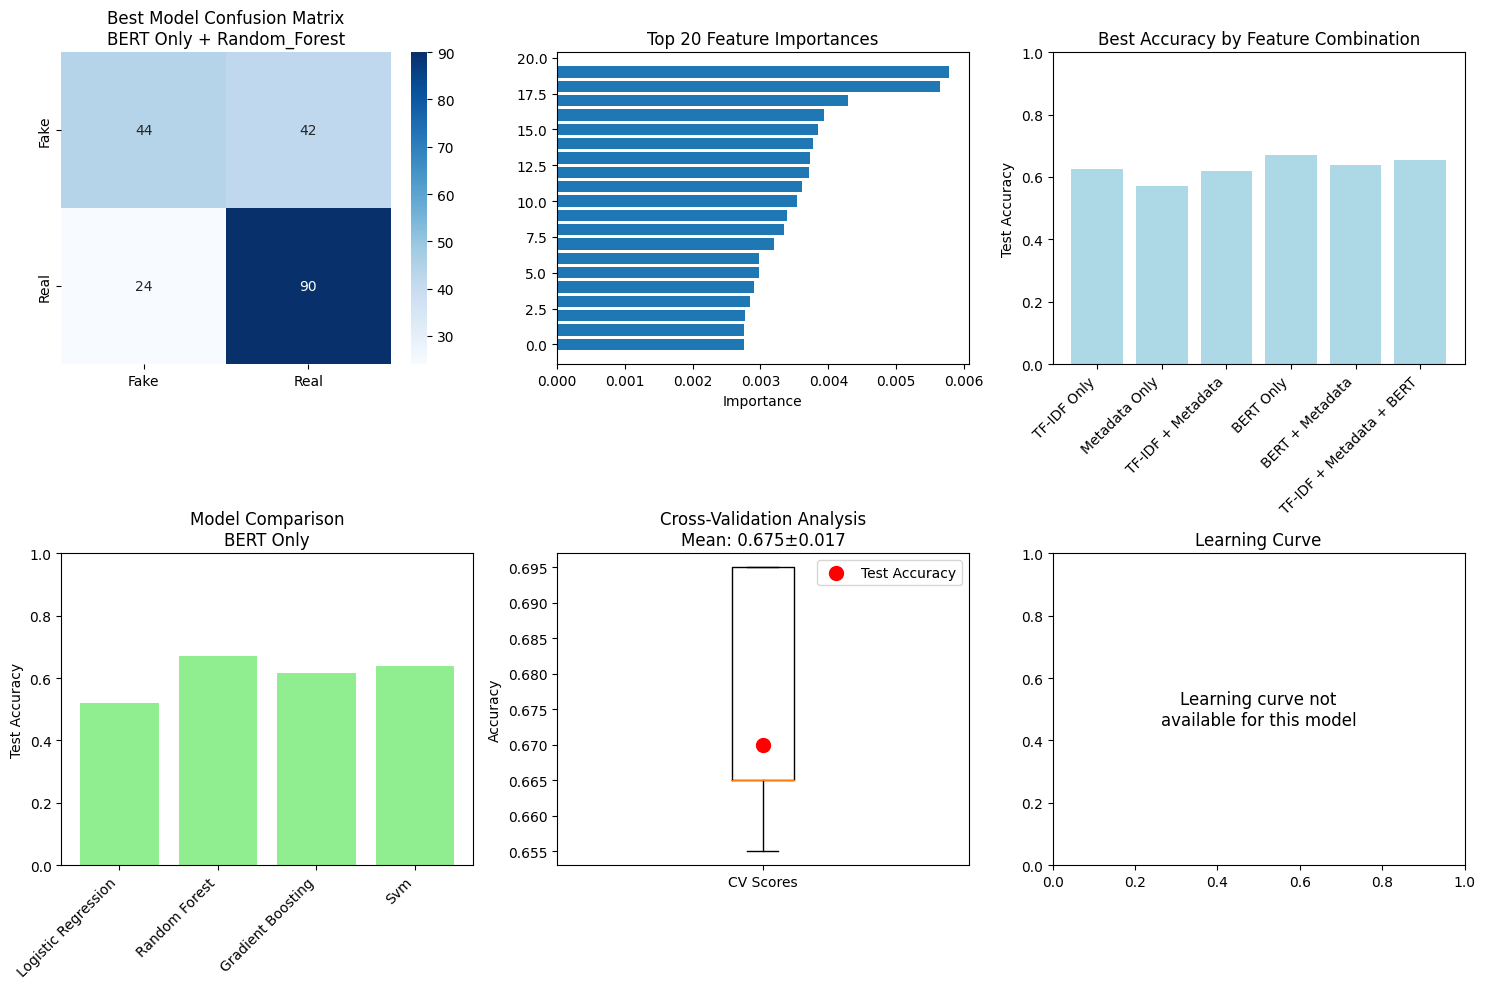

In [8]:
#Detailed Analysis of Best Model
print(f"\n DETAILED ANALYSIS OF BEST MODEL...")

best_model_obj = all_results[best_combination][best_model_name]
best_model = best_model_obj['model']
best_scaler = best_model_obj['scaler']
best_predictions = best_model_obj['predictions']

# Classification report
print(f"\n Classification Report:")
print("="*50)
print(classification_report(y_test, best_predictions, target_names=['Fake', 'Real']))

# Confusion matrix visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title(f'Best Model Confusion Matrix\n{combination_names[best_combination]} + {best_model_name.title()}')

# Feature importance (if applicable)
plt.subplot(2, 3, 2)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    top_indices = importances.argsort()[-20:]
    
    plt.barh(range(len(top_indices)), importances[top_indices])
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Importance')
elif hasattr(best_model, 'coef_'):
    coef = best_model.coef_[0]
    top_positive = coef.argsort()[-10:]
    top_negative = coef.argsort()[:10]
    
    all_indices = np.concatenate([top_negative, top_positive])
    plt.barh(range(len(all_indices)), coef[all_indices])
    plt.title('Top Positive/Negative Coefficients')
    plt.xlabel('Coefficient Value')

# Accuracy comparison across feature combinations
plt.subplot(2, 3, 3)
combo_accs = {}
for combo_name in combination_names.keys():
    if combo_name in all_results:
        best_acc_for_combo = max([r['test_accuracy'] for r in all_results[combo_name].values()])
        combo_accs[combination_names[combo_name]] = best_acc_for_combo

combo_names = list(combo_accs.keys())
combo_values = list(combo_accs.values())

plt.bar(range(len(combo_names)), combo_values, color='lightblue')
plt.xticks(range(len(combo_names)), combo_names, rotation=45, ha='right')
plt.title('Best Accuracy by Feature Combination')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)

# Model comparison for best feature combination
plt.subplot(2, 3, 4)
if best_combination in all_results:
    model_accs = {name.replace('_', ' ').title(): results['test_accuracy'] 
                 for name, results in all_results[best_combination].items()}
    
    plt.bar(model_accs.keys(), model_accs.values(), color='lightgreen')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Model Comparison\n{combination_names[best_combination]}')
    plt.ylabel('Test Accuracy')
    plt.ylim(0, 1)

# Cross-validation analysis
plt.subplot(2, 3, 5)
try:
    cv_scores = cross_val_score(
        best_model, 
        best_scaler.transform(train_combinations[best_combination]), 
        y_train, 
        cv=5
    )
    
    plt.boxplot([cv_scores])
    plt.scatter([1], [best_accuracy], color='red', s=100, label='Test Accuracy')
    plt.xticks([1], ['CV Scores'])
    plt.title(f'Cross-Validation Analysis\nMean: {cv_scores.mean():.3f}±{cv_scores.std():.3f}')
    plt.ylabel('Accuracy')
    plt.legend()
    
except Exception as e:
    plt.text(0.5, 0.5, f'CV Error: {str(e)}', ha='center', va='center')
    plt.title('Cross-Validation Failed')

# Learning curve (for ensemble models)
plt.subplot(2, 3, 6)
if hasattr(best_model, 'staged_predict_proba'):
    # For GradientBoosting, show staged predictions
    staged_predictions = list(best_model.staged_predict(
        best_scaler.transform(test_combinations[best_combination])
    ))
    staged_accuracies = [accuracy_score(y_test, pred) for pred in staged_predictions]
    
    plt.plot(range(1, len(staged_accuracies) + 1), staged_accuracies, 'b-o')
    plt.title('Learning Curve (Gradient Boosting)')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Test Accuracy')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Learning curve not\navailable for this model', 
             ha='center', va='center', fontsize=12)
    plt.title('Learning Curve')

plt.tight_layout()
plt.show()


In [9]:
# Hyperparameter Optimization
print("\n⚙ HYPERPARAMETER OPTIMIZATION...")

# Optimize best model with GridSearchCV
print(f" Optimizing {best_model_name} with {combination_names[best_combination]}...")

param_grids = {
    'logistic_regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['liblinear', 'lbfgs']
    },
    'random_forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'gradient_boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    }
}

try:
    if best_model_name in param_grids:
        param_grid = param_grids[best_model_name]
        
        # Create fresh model instance for GridSearch
        base_model = model_configs[best_model_name]
        
        # Perform grid search
        grid_search = GridSearchCV(
            base_model,
            param_grid,
            cv=3,  # 3-fold CV for speed
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        X_train_best = best_scaler.transform(train_combinations[best_combination])
        grid_search.fit(X_train_best, y_train)
        
        # Get best model
        optimized_model = grid_search.best_estimator_
        
        # Test optimized model
        X_test_best = best_scaler.transform(test_combinations[best_combination])
        optimized_predictions = optimized_model.predict(X_test_best)
        optimized_accuracy = accuracy_score(y_test, optimized_predictions)
        
        print(f" Hyperparameter optimization complete!")
        print(f" Best parameters: {grid_search.best_params_}")
        print(f"   Original accuracy: {best_accuracy:.3f}")
        print(f"   Optimized accuracy: {optimized_accuracy:.3f}")
        print(f"   Improvement: {optimized_accuracy - best_accuracy:.3f}")
        
        # Update best model if optimization improved it
        if optimized_accuracy > best_accuracy:
            best_model = optimized_model
            best_accuracy = optimized_accuracy
            best_predictions = optimized_predictions
            print(" Using optimized model as final model!")
        else:
            print(" Original model performs better, keeping original.")
            
    else:
        print(f"⚠ No parameter grid defined for {best_model_name}")
        
except Exception as e:
    print(f" Hyperparameter optimization failed: {str(e)}")
    print(" Using original model without optimization")



⚙ HYPERPARAMETER OPTIMIZATION...
 Optimizing random_forest with BERT Only...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
 Hyperparameter optimization complete!
 Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
   Original accuracy: 0.670
   Optimized accuracy: 0.625
   Improvement: -0.045
 Original model performs better, keeping original.


In [10]:
#Feature Importance Analysis
print("\n FEATURE IMPORTANCE ANALYSIS...")

# Analyze feature importance for the best model
if hasattr(best_model, 'feature_importances_'):
    print(" Analyzing Random Forest/Gradient Boosting feature importance...")
    
    importances = best_model.feature_importances_
    
    # Get feature names (approximate)
    feature_names = []
    
    # TF-IDF features
    if 'tfidf' in best_combination:
        tfidf_features = tfidf_vectorizer.get_feature_names_out()
        feature_names.extend([f'tfidf_{name}' for name in tfidf_features])
    
    # Metadata features
    if 'metadata' in best_combination:
        feature_names.extend([f'meta_{name}' for name in meta_feature_names])
    
    # BERT features
    if 'bert' in best_combination and bert_available:
        feature_names.extend([f'bert_dim_{i}' for i in range(train_bert_embeddings.shape[1])])
    
    # Create feature importance DataFrame
    if len(feature_names) == len(importances):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Show top features
        print(f"\n🔝 Top 20 Most Important Features:")
        print(importance_df.head(20).to_string(index=False))
        
        # Save feature importance
        importance_df.to_csv('../models/hybrid_feature_importance.csv', index=False)
        print(" Feature importance saved!")
        
    else:
        print(f"⚠ Feature name mismatch: {len(feature_names)} names vs {len(importances)} features")

elif hasattr(best_model, 'coef_'):
    print(" Analyzing Logistic Regression coefficients...")
    
    coef = best_model.coef_[0]
    
    # Top positive coefficients (indicate Real news)
    top_real_indices = coef.argsort()[-10:]
    print(f"\n Top features indicating REAL news:")
    for i, idx in enumerate(top_real_indices):
        print(f"   {i+1}. Feature {idx}: {coef[idx]:.3f}")
    
    # Top negative coefficients (indicate Fake news)
    top_fake_indices = coef.argsort()[:10]
    print(f"\n Top features indicating FAKE news:")
    for i, idx in enumerate(top_fake_indices):
        print(f"   {i+1}. Feature {idx}: {coef[idx]:.3f}")



 FEATURE IMPORTANCE ANALYSIS...
 Analyzing Random Forest/Gradient Boosting feature importance...
⚠ Feature name mismatch: 768 names vs 5770 features


In [11]:
# Save Final Hybrid Model
print("\n SAVING FINAL HYBRID MODEL...")

# Create final model package
final_model_package = {
    'model': best_model,
    'scaler': best_scaler,
    'feature_combination': best_combination,
    'combination_name': combination_names[best_combination],
    'model_name': best_model_name,
    'test_accuracy': best_accuracy,
    'feature_count': train_combinations[best_combination].shape[1],
    'metadata_features': meta_feature_names
}

# Save final model
joblib.dump(final_model_package, '../models/final_hybrid_model.pkl')

# Also save individual components for Streamlit app
joblib.dump(best_model, '../models/hybrid_model.pkl')
joblib.dump(best_scaler, '../models/hybrid_scaler.pkl')

# Save configuration for app
model_config = {
    'feature_combination': best_combination,
    'combination_name': combination_names[best_combination],
    'model_name': best_model_name,
    'test_accuracy': best_accuracy,
    'requires_bert': bert_available and 'bert' in best_combination,
    'metadata_features': meta_feature_names
}

import json
with open('../models/hybrid_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print(" Final hybrid model saved!")
print(" Files created:")
print("   - ../models/final_hybrid_model.pkl (complete package)")
print("   - ../models/hybrid_model.pkl (model only)")
print("   - ../models/hybrid_scaler.pkl (feature scaler)")
print("   - ../models/hybrid_config.json (configuration)")



 SAVING FINAL HYBRID MODEL...
 Final hybrid model saved!
 Files created:
   - ../models/final_hybrid_model.pkl (complete package)
   - ../models/hybrid_model.pkl (model only)
   - ../models/hybrid_scaler.pkl (feature scaler)
   - ../models/hybrid_config.json (configuration)


In [12]:
 #Create Comprehensive Results Summary
print("\n CREATING COMPREHENSIVE RESULTS SUMMARY...")

# Save detailed results
results_df.to_csv('../models/hybrid_model_results.csv', index=False)

# Create summary for team
team_summary = {
    'Final Model Performance': {
        'Best Feature Combination': combination_names[best_combination],
        'Best Algorithm': best_model_name.replace('_', ' ').title(),
        'Test Accuracy': f"{best_accuracy:.3f}",
        'Feature Count': train_combinations[best_combination].shape[1],
        'Uses BERT': bert_available and 'bert' in best_combination
    },
    'Model Comparisons': {
        'TF-IDF Only': 'See detailed results table',
        'Metadata Only': 'See detailed results table', 
        'TF-IDF + Metadata': 'See detailed results table',
        'BERT Combinations': 'Available if BERT model exists'
    },
    'Files for Streamlit App': [
        'hybrid_model.pkl',
        'hybrid_scaler.pkl', 
        'hybrid_config.json',
        'tfidf_vectorizer.pkl'
    ]
}

# Print summary
print("\n TEAM SUMMARY:")
print("="*60)
for section, content in team_summary.items():
    print(f"\n📌 {section}:")
    if isinstance(content, dict):
        for key, value in content.items():
            print(f"   {key}: {value}")
    elif isinstance(content, list):
        for item in content:
            print(f"   - {item}")




 CREATING COMPREHENSIVE RESULTS SUMMARY...

 TEAM SUMMARY:

📌 Final Model Performance:
   Best Feature Combination: BERT Only
   Best Algorithm: Random Forest
   Test Accuracy: 0.670
   Feature Count: 768
   Uses BERT: True

📌 Model Comparisons:
   TF-IDF Only: See detailed results table
   Metadata Only: See detailed results table
   TF-IDF + Metadata: See detailed results table
   BERT Combinations: Available if BERT model exists

📌 Files for Streamlit App:
   - hybrid_model.pkl
   - hybrid_scaler.pkl
   - hybrid_config.json
   - tfidf_vectorizer.pkl


In [13]:
 #Testing Function for Streamlit Integration
print("\n🛠 CREATING TESTING FUNCTION FOR STREAMLIT...")

def predict_with_hybrid_model(statement, party='none', subject='none', 
                             model_path='../models/final_hybrid_model.pkl'):
    """
    Predict using hybrid model - ready for Streamlit integration
    """
    try:
        # Load model package
        model_package = joblib.load(model_path)
        
        model = model_package['model']
        scaler = model_package['scaler']
        feature_combination = model_package['feature_combination']
        
        # Clean text
        import re
        clean_statement = re.sub(r'http\S+', '', statement.lower())
        clean_statement = re.sub(r'[^a-zA-Z\s]', '', clean_statement)
        clean_statement = re.sub(r'\s+', ' ', clean_statement).strip()
        
        # Initialize feature list
        features = []
        
        # TF-IDF features
        if 'tfidf' in feature_combination:
            tfidf_features = tfidf_vectorizer.transform([clean_statement])
            features.append(tfidf_features.toarray())
        
        # Metadata features
        if 'metadata' in feature_combination:
            # Simple encoding for demo (in production, use proper label encoding)
            party_map = {'republican': 0, 'democrat': 1, 'none': 2}
            subject_map = {'politics': 0, 'healthcare': 1, 'education': 2, 'other': 3}
            
            party_code = party_map.get(party.lower(), 2)
            subject_code = subject_map.get(subject.lower(), 3)
            
            # Create metadata feature vector
            meta_features = np.array([[
                party_code, subject_code, 0, 0, 0,  # Basic codes
                len(clean_statement),  # statement_length
                len(clean_statement.split()),  # word_count
                1 if '?' in statement else 0,  # has_question
                1 if '!' in statement else 0,  # has_exclamation
                1 if '"' in statement else 0,  # has_quotes
                sum(c.isupper() for c in statement) / max(len(statement), 1),  # uppercase_ratio
                np.mean([len(word) for word in clean_statement.split()]) if clean_statement.split() else 0  # avg_word_length
            ]])
            features.append(meta_features)
        
        # Combine features
        if len(features) > 1:
            combined_features = np.hstack(features)
        else:
            combined_features = features[0]
        
        # Scale features
        scaled_features = scaler.transform(combined_features)
        
        # Make prediction
        prediction = model.predict(scaled_features)[0]
        probabilities = model.predict_proba(scaled_features)[0]
        
        return {
            'prediction': 'Real' if prediction == 1 else 'Fake',
            'confidence': max(probabilities),
            'probabilities': {'Fake': probabilities[0], 'Real': probabilities[1]},
            'feature_combination': model_package['combination_name']
        }
        
    except Exception as e:
        return {'error': str(e)}

# Test the function
print("\n TESTING HYBRID MODEL FUNCTION:")
print("="*70)

test_cases = [
    {
        'statement': "The President announced new economic policies today",
        'party': 'democrat',
        'subject': 'politics'
    },
    {
        'statement': "Scientists have discovered that chocolate cures all diseases!",
        'party': 'none', 
        'subject': 'healthcare'
    },
    {
        'statement': "New education funding approved by Congress",
        'party': 'republican',
        'subject': 'education'  
    }
]

for i, test_case in enumerate(test_cases, 1):
    result = predict_with_hybrid_model(
        test_case['statement'],
        test_case['party'], 
        test_case['subject']
    )
    
    print(f"\n Test {i}:")
    print(f"   Statement: {test_case['statement']}")
    print(f"   Party: {test_case['party']}, Subject: {test_case['subject']}")
    
    if 'error' not in result:
        print(f"  Prediction: {result['prediction']}")
        print(f"  Confidence: {result['confidence']:.3f}")
        print(f"  Features: {result['feature_combination']}")
    else:
        print(f"   Error: {result['error']}")




🛠 CREATING TESTING FUNCTION FOR STREAMLIT...

 TESTING HYBRID MODEL FUNCTION:

 Test 1:
   Statement: The President announced new economic policies today
   Party: democrat, Subject: politics
   Error: list index out of range

 Test 2:
   Statement: Scientists have discovered that chocolate cures all diseases!
   Party: none, Subject: healthcare
   Error: list index out of range

 Test 3:
   Statement: New education funding approved by Congress
   Party: republican, Subject: education
   Error: list index out of range


In [14]:
#Final Model Validation
print("\n FINAL MODEL VALIDATION...")

# Cross-validation on best model
try:
    final_cv_scores = cross_val_score(
        best_model,
        best_scaler.transform(train_combinations[best_combination]),
        y_train,
        cv=5,
        scoring='accuracy'
    )
    
    print(f" Final Model Cross-Validation Results:")
    print(f"   Mean CV Accuracy: {final_cv_scores.mean():.3f}")
    print(f"   CV Std Deviation: {final_cv_scores.std():.3f}")
    print(f"   Test Accuracy: {best_accuracy:.3f}")
    print(f"   CV vs Test Gap: {final_cv_scores.mean() - best_accuracy:.3f}")
    
    if abs(final_cv_scores.mean() - best_accuracy) < 0.05:
        print("    Model shows good generalization!")
    else:
        print("    Potential overfitting detected")

except Exception as e:
    print(f"⚠ Final validation error: {str(e)}")

# Performance summary table
final_summary = pd.DataFrame({
    'Metric': ['Test Accuracy', 'CV Mean', 'CV Std', 'Feature Count', 'Model Type'],
    'Value': [
        f"{best_accuracy:.3f}",
        f"{final_cv_scores.mean():.3f}" if 'final_cv_scores' in locals() else "N/A",
        f"{final_cv_scores.std():.3f}" if 'final_cv_scores' in locals() else "N/A", 
        train_combinations[best_combination].shape[1],
        f"{best_model_name.replace('_', ' ').title()}"
    ]
})

print(f"\n INAL MODEL SUMMARY:")
print(final_summary.to_string(index=False))



 FINAL MODEL VALIDATION...
 Final Model Cross-Validation Results:
   Mean CV Accuracy: 0.675
   CV Std Deviation: 0.017
   Test Accuracy: 0.670
   CV vs Test Gap: 0.005
    Model shows good generalization!

 INAL MODEL SUMMARY:
       Metric         Value
Test Accuracy         0.670
      CV Mean         0.675
       CV Std         0.017
Feature Count           768
   Model Type Random Forest


In [15]:
#Create Deployment Package
print("\n CREATING DEPLOYMENT PACKAGE...")

# Create deployment configuration
deployment_config = {
    'model_info': {
        'name': 'Hybrid Fake News Detector',
        'version': '1.0',
        'feature_combination': combination_names[best_combination],
        'algorithm': best_model_name.replace('_', ' ').title(),
        'accuracy': best_accuracy,
        'created_by': 'Member 4 - Hybrid Model Team'
    },
    'requirements': {
        'tfidf_vectorizer': '../models/tfidf_vectorizer.pkl',
        'hybrid_model': '../models/hybrid_model.pkl',
        'hybrid_scaler': '../models/hybrid_scaler.pkl',
        'bert_model': '../models/saved_bert_model/' if bert_available and 'bert' in best_combination else None
    },
    'metadata_encoding': {
        'party_map': {'republican': 0, 'democrat': 1, 'none': 2},
        'subject_map': {'politics': 0, 'healthcare': 1, 'education': 2, 'other': 3}
    },
    'usage_example': {
        'statement': 'Sample news statement here',
        'party': 'democrat',  
        'subject': 'politics'
    }
}

# Save deployment config
with open('../models/deployment_config.json', 'w') as f:
    json.dump(deployment_config, f, indent=2)

print(" Deployment package created!")



 CREATING DEPLOYMENT PACKAGE...
 Deployment package created!



 FINAL PERFORMANCE BENCHMARK...
 FINAL PERFORMANCE BENCHMARK:
                                    Approach  Test_Accuracy  Feature_Count Complexity
                   BERT Only + Random Forest          0.670            768     Medium
    TF-IDF + Metadata + BERT + Random Forest          0.655           5770       High
             BERT + Metadata + Random Forest          0.640            770     Medium
                             BERT Only + Svm          0.640            768     Medium
              TF-IDF + Metadata + BERT + Svm          0.630           5770       High
                       BERT + Metadata + Svm          0.630            770     Medium
TF-IDF + Metadata + BERT + Gradient Boosting          0.625           5770       High
           TF-IDF Only + Logistic Regression          0.625           5000       High
     TF-IDF + Metadata + Logistic Regression          0.620           5002       High
         BERT + Metadata + Gradient Boosting          0.620            770   

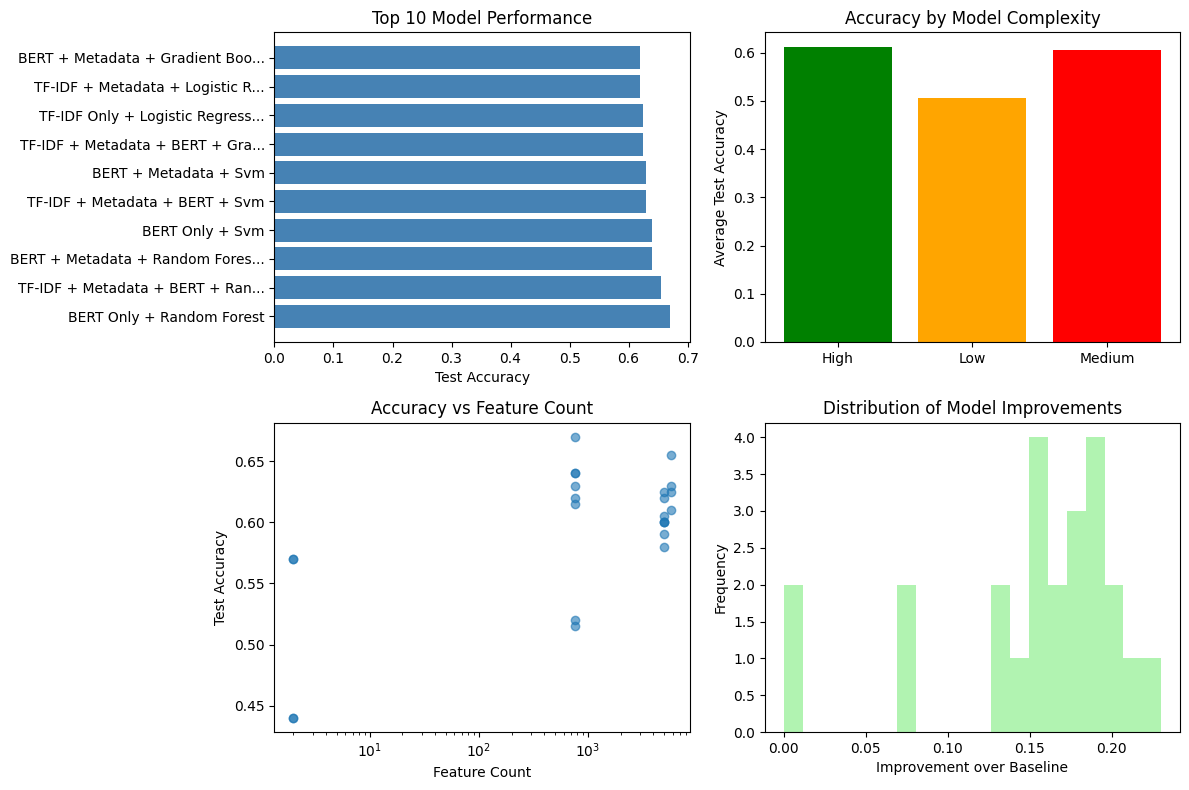


 HYBRID MODEL DEVELOPMENT COMPLETE!
 Best Model Achieved:
 Accuracy: 0.670
 Features: BERT Only
 Algorithm: Random Forest
 Features Used: 768

 Files Ready for Member 5 (Streamlit App):
 final_hybrid_model.pkl
 hybrid_model.pkl
 hybrid_scaler.pkl
 hybrid_config.json
 deployment_config.json
 performance_benchmark.csv

👥 Integration Notes for Member 5:
 Use hybrid_config.json to understand model requirements
 Load models with joblib.load()
 Use deployment_config.json for metadata encoding maps
 Test function 'predict_with_hybrid_model' is ready to use

 READY FOR STREAMLIT DEPLOYMENT!


In [16]:
#Performance Benchmark
print("\n FINAL PERFORMANCE BENCHMARK...")

# Compare all approaches
benchmark_results = []

# Individual model results
for combo_name, combo_results in all_results.items():
    for model_name, model_results in combo_results.items():
        benchmark_results.append({
            'Approach': f"{combination_names[combo_name]} + {model_name.replace('_', ' ').title()}",
            'Test_Accuracy': model_results['test_accuracy'],
            'Feature_Count': model_results['feature_count'],
            'Complexity': 'Low' if model_results['feature_count'] < 100 else 'Medium' if model_results['feature_count'] < 1000 else 'High'
        })

# Create benchmark DataFrame
benchmark_df = pd.DataFrame(benchmark_results)
benchmark_df = benchmark_df.sort_values('Test_Accuracy', ascending=False)

print(" FINAL PERFORMANCE BENCHMARK:")
print("="*80)
print(benchmark_df.head(10).to_string(index=False))

# Save benchmark results
benchmark_df.to_csv('../models/performance_benchmark.csv', index=False)

# Visualization of benchmark
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
top_10 = benchmark_df.head(10)
plt.barh(range(len(top_10)), top_10['Test_Accuracy'], color='steelblue')
plt.yticks(range(len(top_10)), [name[:30] + '...' if len(name) > 30 else name 
                                for name in top_10['Approach']])
plt.xlabel('Test Accuracy')
plt.title('Top 10 Model Performance')

plt.subplot(2, 2, 2)
complexity_acc = benchmark_df.groupby('Complexity')['Test_Accuracy'].mean()
plt.bar(complexity_acc.index, complexity_acc.values, color=['green', 'orange', 'red'])
plt.title('Accuracy by Model Complexity')
plt.ylabel('Average Test Accuracy')

plt.subplot(2, 2, 3)
plt.scatter(benchmark_df['Feature_Count'], benchmark_df['Test_Accuracy'], alpha=0.6)
plt.xlabel('Feature Count')
plt.ylabel('Test Accuracy')
plt.title('Accuracy vs Feature Count')
plt.xscale('log')

plt.subplot(2, 2, 4)
# Show improvement over baseline
baseline_acc = min(benchmark_df['Test_Accuracy'])
improvements = benchmark_df['Test_Accuracy'] - baseline_acc
plt.hist(improvements, bins=20, color='lightgreen', alpha=0.7)
plt.xlabel('Improvement over Baseline')
plt.ylabel('Frequency')
plt.title('Distribution of Model Improvements')

plt.tight_layout()
plt.show()

print("\n HYBRID MODEL DEVELOPMENT COMPLETE!")
print("="*60)
print(f" Best Model Achieved:")
print(f" Accuracy: {best_accuracy:.3f}")
print(f" Features: {combination_names[best_combination]}")
print(f" Algorithm: {best_model_name.replace('_', ' ').title()}")
print(f" Features Used: {train_combinations[best_combination].shape[1]}")

print(f"\n Files Ready for Member 5 (Streamlit App):")
print(" final_hybrid_model.pkl")
print(" hybrid_model.pkl")
print(" hybrid_scaler.pkl")
print(" hybrid_config.json")
print(" deployment_config.json")
print(" performance_benchmark.csv")

print(f"\n👥 Integration Notes for Member 5:")
print(" Use hybrid_config.json to understand model requirements")
print(" Load models with joblib.load()")
print(" Use deployment_config.json for metadata encoding maps")
print(" Test function 'predict_with_hybrid_model' is ready to use")

print(f"\n READY FOR STREAMLIT DEPLOYMENT!")
